# Imports

In [1]:
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path

import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Constants

In [2]:
BATCH_SIZE = 32
EPOCHS = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
DEVICE

device(type='cpu')

### Set seed

In [3]:
import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

# Read Data

In [4]:
dataset_path = Path().resolve() / "wine"
dataset_path
df_red = pd.read_csv(dataset_path / "winequality-red.csv", sep=';')
df_white = pd.read_csv(dataset_path / "winequality-white.csv", sep=';')
df_red['color'] = 1
df_white['color'] = 0
df = pd.concat([df_red, df_white], ignore_index=True)

In [5]:
X = df.drop('quality', axis=1).values
y = df['quality'].values

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42,
)

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [8]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train - 3, dtype=torch.long).squeeze()
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val - 3, dtype=torch.long).squeeze()

# Substract 3 because quality is from 3 to 9, and we want it from 0 to 6

In [9]:
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

In [10]:
n_features = X_train.shape[1]
n_classes = len(np.unique(y))

# Prepare pipeline

In [11]:
class MLP(nn.Module):
    def __init__(self, hidden_layers : list[int] = [64, 32], activation = nn.ReLU):
        super().__init__()
        layers = []
        in_dim = n_features
        for h in hidden_layers:
            layers.append(nn.Linear(in_dim, h))
            layers.append(activation())
            in_dim = h
        layers.append(nn.Linear(in_dim, n_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [12]:
def train_model(model: nn.Module, optimizer: torch.optim, epochs: int, lr: float):
    criterion = nn.CrossEntropyLoss()
    opt = optimizer(model.parameters(), lr=lr)
    
    writer = SummaryWriter(f'runs/PyTorch_{model.__class__.__name__}')
    global_step = 0

    for ep in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            logits = model(xb)
            loss = criterion(logits, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item()*xb.size(0)
            
            writer.add_scalar('Loss/Train_Batch', loss.item(), global_step)
            global_step += 1
        avg_loss = total_loss / len(train_loader.dataset)

        model.eval()
        xb_val,yb_val = next(iter(val_loader))
        with torch.no_grad():
            logits = model(xb_val)
            val_loss = criterion(logits, yb_val).item()
            preds = torch.argmax(logits, dim=1)
            acc = (preds == yb_val).float().mean().item()

        writer.add_scalar('Loss/Train_Epoch', avg_loss, ep)
        writer.add_scalar('Loss/Validation', val_loss, ep)
        writer.add_scalar('Accuracy/Validation', acc, ep)
        writer.add_scalar('Learning_Rate', opt.param_groups[0]['lr'], ep)

        if ep % 10 == 0 or ep == epochs-1:
            print(f"Epoch {ep:02d} | train_loss={avg_loss:.4f} val_loss={val_loss:.4f} acc={acc:.4f}")

    writer.close()
    return model

In [13]:
configs = [
    {
        "name"   : "Config_1_ReLU_AdamW",
        "hidden" : [64, 32],
        "act"    : nn.ReLU,
        "opt"    : torch.optim.AdamW,
        "lr"     : 1e-3,
    },
    {
        "name"   : "Config_2_ReLU_Adam",
        "hidden" : [128, 64, 32],
        "act"    : nn.ReLU,
        "opt"    : torch.optim.Adam,
        "lr"     : 5e-4,
    },
    {
        "name"   : "Config_3_Tanh_AdamW",
        "hidden" : [128, 64],
        "act"    : nn.Tanh,
        "opt"    : torch.optim.AdamW,
        "lr"     : 1e-3,
    },
]

best_model = None
best_acc = 0

for i, cfg in enumerate(configs):
    print("Config:", cfg)
    model = MLP(hidden_layers=cfg["hidden"], activation=cfg["act"])
    
    criterion = nn.CrossEntropyLoss()
    opt = cfg["opt"](model.parameters(), lr=cfg["lr"])
    
    writer = SummaryWriter(f'runs/PyTorch_{cfg["name"]}')
    global_step = 0

    for ep in range(EPOCHS):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            logits = model(xb)
            loss = criterion(logits, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item()*xb.size(0)
            
            writer.add_scalar('Loss/Train_Batch', loss.item(), global_step)
            global_step += 1
        avg_loss = total_loss / len(train_loader.dataset)

        model.eval()
        xb_val,yb_val = next(iter(val_loader))
        with torch.no_grad():
            logits = model(xb_val)
            val_loss = criterion(logits, yb_val).item()
            preds = torch.argmax(logits, dim=1)
            acc = (preds == yb_val).float().mean().item()

        writer.add_scalar('Loss/Train_Epoch', avg_loss, ep)
        writer.add_scalar('Loss/Validation', val_loss, ep)
        writer.add_scalar('Accuracy/Validation', acc, ep)
        writer.add_scalar('Learning_Rate', opt.param_groups[0]['lr'], ep)

        if ep % 10 == 0 or ep == EPOCHS-1:
            print(f"Epoch {ep:02d} | train_loss={avg_loss:.4f} val_loss={val_loss:.4f} acc={acc:.4f}")

    writer.close()

    model.eval()
    xb_val, yb_val = next(iter(val_loader))
    with torch.no_grad():
        logits = model(xb_val)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == yb_val).float().mean().item()

    print(f"Val accuracy = {acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        best_model = model

Config: {'name': 'Config_1_ReLU_AdamW', 'hidden': [64, 32], 'act': <class 'torch.nn.modules.activation.ReLU'>, 'opt': <class 'torch.optim.adamw.AdamW'>, 'lr': 0.001}


Epoch 00 | train_loss=1.3344 val_loss=1.1178 acc=0.4375
Epoch 10 | train_loss=1.0009 val_loss=1.0047 acc=0.4688
Epoch 10 | train_loss=1.0009 val_loss=1.0047 acc=0.4688
Epoch 20 | train_loss=0.9615 val_loss=0.9490 acc=0.5625
Epoch 20 | train_loss=0.9615 val_loss=0.9490 acc=0.5625
Epoch 30 | train_loss=0.9364 val_loss=0.9475 acc=0.5312
Epoch 30 | train_loss=0.9364 val_loss=0.9475 acc=0.5312
Epoch 40 | train_loss=0.9136 val_loss=0.9661 acc=0.5938
Epoch 40 | train_loss=0.9136 val_loss=0.9661 acc=0.5938
Epoch 50 | train_loss=0.8967 val_loss=0.9505 acc=0.5938
Epoch 50 | train_loss=0.8967 val_loss=0.9505 acc=0.5938
Epoch 60 | train_loss=0.8812 val_loss=0.9663 acc=0.5625
Epoch 60 | train_loss=0.8812 val_loss=0.9663 acc=0.5625
Epoch 70 | train_loss=0.8711 val_loss=0.9446 acc=0.6562
Epoch 70 | train_loss=0.8711 val_loss=0.9446 acc=0.6562
Epoch 80 | train_loss=0.8560 val_loss=0.9178 acc=0.6250
Epoch 80 | train_loss=0.8560 val_loss=0.9178 acc=0.6250
Epoch 90 | train_loss=0.8459 val_loss=0.9780 acc

Classification report:
              precision    recall  f1-score   support

           0       0.33      0.17      0.22         6
           1       0.25      0.12      0.16        43
           2       0.60      0.67      0.63       402
           3       0.62      0.64      0.63       597
           4       0.54      0.49      0.51       215
           5       0.53      0.25      0.34        36
           6       0.00      0.00      0.00         1

    accuracy                           0.60      1300
   macro avg       0.41      0.33      0.36      1300
weighted avg       0.59      0.60      0.59      1300



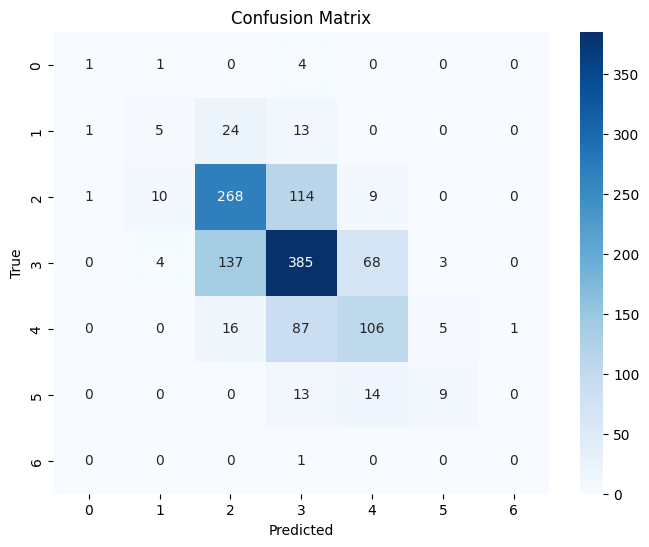

In [14]:
if best_model is not None:
    best_model.eval()
    with torch.no_grad():
        xb, yb = val_loader.dataset.tensors
        preds = torch.argmax(best_model(xb), dim=1)

    print("Classification report:")
    print(classification_report(yb.numpy(), preds.numpy()))

    cm = confusion_matrix(yb.numpy(), preds.numpy())
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
else:
    print("No best model found.")

# Results

Лучше всего модель предсказывает quality=6 (на conf matrix выше классы на 3 меньше реальных).
Вообще не справлсяется с определением качества quality=8, 9
В целом, модель хорошо предсказывает качество в районе 6

# Part 3

In [15]:
from microtorch.layer import Linear, Sequential
from microtorch.loss import CrossEntropyWithLogits
from microtorch.optimizer import AdamOptimizer
from microtorch.activation import ReLU, Tanh

## Test section

#### Test Linear Layer

In [16]:
linear_mt = Linear(5, 10)
linear_pt = nn.Linear(5, 10)

In [17]:
for param in linear_mt.parameters():
    param.value = np.zeros_like(param.value)

for param in linear_pt.parameters():
    param.data.fill_(0)

In [18]:
for _ in range(1000):
    test_x = torch.randn((2, 5))
    out_mt = linear_mt(test_x.numpy().astype(np.float32))
    out_pt = linear_pt(test_x)
    if not np.allclose(out_mt, out_pt.detach().numpy(), rtol=1e-3):
        print("Outputs differ!")
        print("Microtorch output:", out_mt)
        print("Torch output:", out_pt.detach().numpy())
        break
else:
    print("Linear layer outputs match!")

Linear layer outputs match!


#### Test ReLU

In [19]:
relu_mt = ReLU()
relu_pt = nn.ReLU()

In [20]:
for _ in range(1000):
    test_x = torch.randn((2, 5))
    out_mt = relu_mt(test_x.numpy().astype(np.float32))
    out_pt = relu_pt(test_x)
    if not np.allclose(out_mt, out_pt.detach().numpy(), rtol=1e-3):
        print("Outputs differ!")
        print("Microtorch output:", out_mt)
        print("Torch output:", out_pt.detach().numpy())
        break
else:
    print("ReLU outputs match!")

ReLU outputs match!


#### Test Tanh

In [21]:
tanh_mt = Tanh()
tanh_pt = nn.Tanh()

In [22]:
for _ in range(1000):
    test_x = torch.randn((2, 5))
    out_mt = tanh_mt(test_x.numpy().astype(np.float32))
    out_pt = tanh_pt(test_x)
    if not np.allclose(out_mt, out_pt.detach().numpy(), rtol=1e-3):
        print("Outputs differ!")
        print("Microtorch output:", out_mt)
        print("Torch output:", out_pt.detach().numpy())
        break
else:
    print("Tanh outputs match!")

Tanh outputs match!


#### Test Sequential

In [23]:
seq_mt = Sequential(
    Linear(n_features, 64),
    ReLU(),
    Linear(64, 32),
    Tanh(),
    Linear(32, n_classes)
)

seq_pt = nn.Sequential(
    nn.Linear(n_features, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.Tanh(),
    nn.Linear(32, n_classes)
)


In [24]:
for param in seq_mt.parameters():
    param.value = np.ones_like(param.value)

for param in seq_pt.parameters():
    param.data.fill_(1.0)

In [25]:
for _ in range(1000):
    test_x = torch.randn((BATCH_SIZE, n_features))
    out_mt = seq_mt(test_x.numpy().astype(np.float32))
    out_pt = seq_pt(test_x)
    if not np.allclose(out_mt, out_pt.detach().numpy(), rtol=1e-3):
        print("Outputs differ!")
        print("Microtorch output:", out_mt)
        print("Torch output:", out_pt.detach().numpy())
        break
else:
    print("Sequential outputs match!")

Sequential outputs match!


#### Test of gradients

In [26]:
mt_params = seq_mt.parameters()
pt_params = seq_pt.parameters()

In [27]:
pt_loss_fn = nn.CrossEntropyLoss()
mt_loss_fn = CrossEntropyWithLogits()

In [28]:
test_x = torch.randn((8, n_features))
test_y = torch.randint(0, n_classes, (8,))

In [29]:
pt_logits = seq_pt(test_x)
mt_logits = seq_mt(test_x.numpy().astype(np.float32))

In [30]:
pt_loss = pt_loss_fn(pt_logits, test_y)
mt_loss = mt_loss_fn.forward(mt_logits, test_y.numpy())

print("Forward pass comparison:")
print(f"PyTorch loss: {pt_loss.item():.6f}")
print(f"MicroTorch loss: {mt_loss:.6f}")
print(f"Logits match: {np.allclose(pt_logits.detach().numpy(), mt_logits, atol=1e-5)}")

Forward pass comparison:
PyTorch loss: 1.945910
MicroTorch loss: 1.945910
Logits match: True


In [31]:
pt_loss.backward()

mt_grad_output = mt_loss_fn.backward()
seq_mt.backward(mt_grad_output)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [32]:
for pt_param, mt_param in zip(
    seq_pt.parameters(),
    seq_mt.parameters(),
):
    if not np.allclose(pt_param.data.detach().numpy(), mt_param.value, atol=1e-5):
        print(f"Parameter values differ! PT: {pt_param.name}, MT: {mt_param.name}")
        break
    
    if not np.allclose(pt_param.grad.detach().numpy(), mt_param.grad, atol=1e-5):
        print(f"Parameter gradients differ! PT: {pt_param.name}, MT: {mt_param.name}")
        print("PyTorch grad:", pt_param.grad.detach().numpy())
        print("Microtorch grad:", mt_param.grad)
        break
else:
    print("Complete!")


Complete!


# Train Model

In [33]:
mt_model = Sequential(
    Linear(n_features, 128),
    Tanh(),
    Linear(128, 64),
    Tanh(),
    Linear(64, n_classes)
)

In [34]:
criterion = CrossEntropyWithLogits()
opt = AdamOptimizer(
    model        = mt_model,
    lr           = 1e-3,
    weight_decay = 0.00,
)

In [35]:
writer = SummaryWriter(f'runs/MicroTorch_Model')
global_step = 0

for ep in range(EPOCHS):
    total_loss = 0.0
    for xb, yb in train_loader:
        xb_np = xb.numpy().astype(np.float32)
        yb_np = yb.numpy().astype(np.int64)

        logits = mt_model(xb_np)
        loss = criterion.forward(logits, yb_np)

        opt.zero_grad()
        grad = criterion.backward()
        mt_model.backward(grad)
        
        opt.step()
        
        total_loss += float(loss) * xb_np.shape[0]
        
        writer.add_scalar('Loss/Train_Batch', float(loss), global_step)
        global_step += 1
    avg_loss = total_loss / len(train_loader.dataset)

    xb_val, yb_val = next(iter(val_loader))
    xb_val_np = xb_val.numpy().astype(np.float32)
    yb_val_np = yb_val.numpy().astype(np.int64)
    val_logits = mt_model(xb_val_np)
    val_loss = criterion.forward(val_logits, yb_val_np)
    val_preds = np.argmax(val_logits, axis=1)
    acc = float(np.mean(val_preds == yb_val_np))
    
    writer.add_scalar('Loss/Train_Epoch', avg_loss, ep)
    writer.add_scalar('Loss/Validation', float(val_loss), ep)
    writer.add_scalar('Accuracy/Validation', acc, ep)
    writer.add_scalar('Learning_Rate', opt.lr, ep)

    if ep % 10 == 0 or ep == EPOCHS-1:
        print(f"Epoch {ep:02d} | train_loss={avg_loss:.4f} val_loss={float(val_loss):.4f} acc={acc:.4f}")

writer.close()

Epoch 00 | train_loss=1.2891 val_loss=1.0541 acc=0.4688


Epoch 10 | train_loss=1.0080 val_loss=0.9969 acc=0.4688
Epoch 20 | train_loss=0.9564 val_loss=0.8809 acc=0.5625
Epoch 20 | train_loss=0.9564 val_loss=0.8809 acc=0.5625
Epoch 30 | train_loss=0.9075 val_loss=0.8821 acc=0.5938
Epoch 30 | train_loss=0.9075 val_loss=0.8821 acc=0.5938
Epoch 40 | train_loss=0.8618 val_loss=0.8557 acc=0.6562
Epoch 40 | train_loss=0.8618 val_loss=0.8557 acc=0.6562
Epoch 50 | train_loss=0.8134 val_loss=0.8539 acc=0.6875
Epoch 50 | train_loss=0.8134 val_loss=0.8539 acc=0.6875
Epoch 60 | train_loss=0.7721 val_loss=0.8728 acc=0.7188
Epoch 60 | train_loss=0.7721 val_loss=0.8728 acc=0.7188
Epoch 70 | train_loss=0.7274 val_loss=0.8730 acc=0.6562
Epoch 70 | train_loss=0.7274 val_loss=0.8730 acc=0.6562
Epoch 80 | train_loss=0.6865 val_loss=0.9117 acc=0.6562
Epoch 80 | train_loss=0.6865 val_loss=0.9117 acc=0.6562
Epoch 90 | train_loss=0.6400 val_loss=0.9120 acc=0.6875
Epoch 90 | train_loss=0.6400 val_loss=0.9120 acc=0.6875
Epoch 99 | train_loss=0.6019 val_loss=0.9417 acc

Final validation accuracy: 0.5746
Classification report:
              precision    recall  f1-score   support

           0       0.50      0.17      0.25         6
           1       0.30      0.14      0.19        43
           2       0.57      0.69      0.62       402
           3       0.61      0.59      0.60       597
           4       0.52      0.47      0.49       215
           5       0.50      0.25      0.33        36
           6       0.00      0.00      0.00         1

    accuracy                           0.57      1300
   macro avg       0.43      0.33      0.36      1300
weighted avg       0.57      0.57      0.57      1300



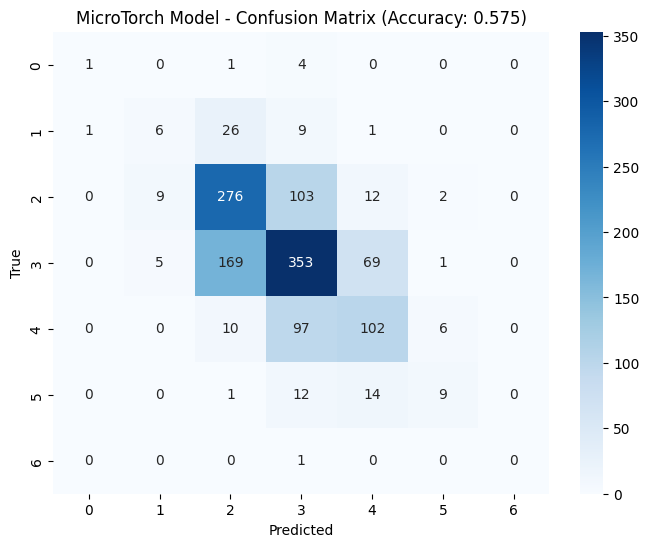

Final accuracy: 0.5746


In [36]:
X_val_np = X_val.numpy().astype(np.float32)
y_val_np = (y_val).numpy().astype(np.int64)

val_logits = mt_model(X_val_np)
val_preds = np.argmax(val_logits, axis=1)
val_accuracy = np.mean(val_preds == y_val_np)

print(f"Final validation accuracy: {val_accuracy:.4f}")
print("Classification report:")
print(classification_report(y_val_np, val_preds))

# Confusion matrix
cm = confusion_matrix(y_val_np, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"MicroTorch Model - Confusion Matrix (Accuracy: {val_accuracy:.3f})")
plt.show()

print(f"Final accuracy: {val_accuracy:.4f}")